<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/HopfieldNetwork_EBMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HopfieldNetwork

### Training

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define your dataset
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Create a DataLoader
data_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Define the number of epochs
num_epochs = 10

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0


def calculate_loss(initial_state, updated_state, model):
    initial_energy = model.energy(initial_state)
    updated_energy = model.energy(updated_state)
    return torch.mean(updated_energy - initial_energy)  # CD loss


# Define your Hopfield network model
class HopfieldNetwork(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetwork, self).__init__()
        # Initialize weights with small random values
        self.weights = nn.Parameter(torch.randn(num_neurons, num_neurons) * 0.01)

    def energy(self, state):
        # Reshape state to a 2D matrix (squeeze the middle dimension)
        state = state.squeeze(1)
        return -0.5 * torch.mm(state, torch.mm(self.weights, state.t()))

    def forward(self, state):
        # Vectorized update rule
        flattened_state = state.view(state.size(0), -1)
        activation = torch.matmul(flattened_state, self.weights.t())
        updated_state = torch.sign(activation)
        return updated_state

    def sample(self, initial_state, num_steps=10):
        """
        Performs Gibbs sampling to generate samples from the model.
        """
        state = initial_state.clone()
        for _ in range(num_steps):
            for i in range(state.size(1)):  # Iterate over neurons
                energy_on = self.energy(state.clone().fill_(1))  # Energy with neuron i ON
                energy_off = self.energy(state.clone().fill_(-1))  # Energy with neuron i OFF
                p_on = torch.exp(-energy_on) / (torch.exp(-energy_on) + torch.exp(-energy_off))
                state[:, i] = torch.bernoulli(p_on) * 2 - 1  # Sample the neuron's state
        return state


# Example usage
model = HopfieldNetwork(num_neurons=784)  # 784 for MNIST images
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm progress bar, CD, and early stopping
for epoch in range(num_epochs):
    epoch_energy = 0
    epoch_loss = 0
    with tqdm(data_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            initial_state = data
            states = model(data)
            energy = model.energy(states)
            mean_energy = torch.mean(energy)
            epoch_energy += mean_energy.item()
            loss = calculate_loss(initial_state, states, model)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

    # Print average energy and loss for the epoch
    avg_epoch_energy = epoch_energy / len(data_loader)
    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"Epoch {epoch+1}: Average Energy = {avg_epoch_energy:.4f}, Average Loss = {avg_epoch_loss:.4f}")

    # Early stopping check
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


def add_noise(images, noise_level=0.3):
    """Adds Gaussian noise to images."""
    noise = torch.randn(images.size()) * noise_level
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0, 1)  # Keep pixel values between 0 and 1
    return noisy_images


def test_reconstruction(model, data_loader, noise_level=0.3, num_updates=10):
    """Tests the network's ability to reconstruct noisy images."""
    with torch.no_grad():
        for data, target in data_loader:
            data = data.view(data.size(0), -1)
            noisy_data = add_noise(data, noise_level)

            # Run the update step multiple times
            current_state = noisy_data.clone()
            for _ in range(num_updates):
                current_state = model(current_state)

            # Visual comparison
            for i in range(data.size(0)):
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(data[i].reshape(28, 28), cmap='gray')
                plt.title('Original')
                plt.subplot(1, 3, 2)
                plt.imshow(noisy_data[i].reshape(28, 28), cmap='gray')
                plt.title('Noisy')
                plt.subplot(1, 3, 3)
                plt.imshow(current_state[i].reshape(28, 28), cmap='gray')
                plt.title('Reconstructed')
                plt.show()


def test_generation(model, num_samples=10, num_steps=100):
    """Tests the network's ability to generate samples."""
    initial_state = torch.randn(num_samples, 784)  # Random initial states
    samples = model.sample(initial_state,
                           num_steps)  # Assuming you've implemented the sample method

    # Visualize the generated samples
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.show()


def visualize_weights(model):
    """Visualizes the learned weight matrix."""
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(model.weights.detach().numpy()[:, i].reshape(28, 28),
                   cmap='gray')
        plt.title(f'Neuron {i}')
    plt.show()


# After training:
#test_reconstruction(model, data_loader)
#test_generation(model)
#visualize_weights(model)

Epoch 1: 100%|██████████| 938/938 [00:34<00:00, 27.02batch/s, loss=-7.23e+3]


Epoch 1: Average Energy = -383.7231, Average Loss = -392.2459


Epoch 2: 100%|██████████| 938/938 [00:35<00:00, 26.30batch/s, loss=-1.18e+4]


Epoch 2: Average Energy = -1661.8903, Average Loss = -1692.9121


Epoch 3: 100%|██████████| 938/938 [00:35<00:00, 26.66batch/s, loss=-7.56e+3]


Epoch 3: Average Energy = -2791.1073, Average Loss = -2846.6778


Epoch 4: 100%|██████████| 938/938 [00:34<00:00, 27.12batch/s, loss=-854]


Epoch 4: Average Energy = -4337.7568, Average Loss = -4418.3326


Epoch 5: 100%|██████████| 938/938 [00:35<00:00, 26.48batch/s, loss=-375]


Epoch 5: Average Energy = -5726.0706, Average Loss = -5832.8943


Epoch 6: 100%|██████████| 938/938 [00:34<00:00, 27.04batch/s, loss=-4.74e+3]


Epoch 6: Average Energy = -6846.1154, Average Loss = -6978.2553


Epoch 7: 100%|██████████| 938/938 [00:35<00:00, 26.63batch/s, loss=-65495.0]


Epoch 7: Average Energy = -9130.1373, Average Loss = -9288.7531


Epoch 8: 100%|██████████| 938/938 [00:35<00:00, 26.64batch/s, loss=-126]


Epoch 8: Average Energy = -9188.8458, Average Loss = -9373.5295


Epoch 9: 100%|██████████| 938/938 [00:34<00:00, 27.22batch/s, loss=-1.55e+4]


Epoch 9: Average Energy = -10106.5146, Average Loss = -10316.1774


Epoch 10: 100%|██████████| 938/938 [00:35<00:00, 26.59batch/s, loss=-5.07e+4]

Epoch 10: Average Energy = -11957.1898, Average Loss = -12192.9030


### Evaluation


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            # Flatten the input data
            data = data.view(data.size(0), -1)
            # Update the state using the model
            updated_state = model(data)
            # Calculate the energy of the updated state
            test_loss += torch.mean(model.energy(updated_state)).item()

    test_loss /= len(test_loader)
    print(f"Eval Loss: {test_loss:.4f}")

# Assuming 'model' is your trained HopfieldNetwork instance
evaluate(model, test_loader)

Eval Loss: -21015.2544


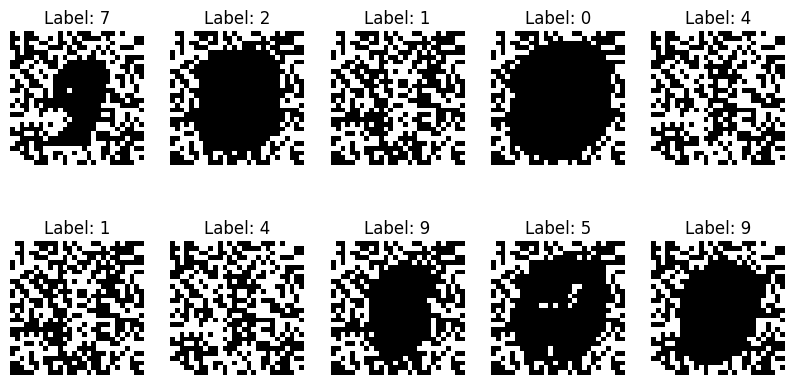

In [4]:
import matplotlib.pyplot as plt


# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Flatten and pass through the model
flattened_images = images.view(images.size(0), -1)
updated_states = model(flattened_images)

# Reshape updated states back to images
reconstructed_images = updated_states.view(-1, 28, 28)

# Plot some reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_images[i].detach().numpy(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.show()